In [1]:
import numpy as np
import pandas as pd
import re

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import scipy.stats as st
import scipy


from sklearn.utils import resample
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class Data:
    """
    Load the data categorize the columns to categorical and numerical
    """
    def __init__(self, filepath: str = None, targetcol: str = None):
        self.data = pd.read_csv(filepath)
        self.targetcol = targetcol

    def get_numericals(self):
        self.num_cols = list(self.data.dtypes[
            (self.data.dtypes == 'int64') | (self.data.dtypes == 'float64')| 
            (self.data.dtypes == 'int32') | (self.data.dtypes == 'float32')|
            (self.data.dtypes == 'int16') | (self.data.dtypes == 'float16')|
            (self.data.dtypes == 'int8')].keys())
        if self.targetcol in self.num_cols:
            self.num_cols.remove(self.targetcol)
        self.cat_cols = list(set(self.data.columns).difference(self.num_cols))
        if self.targetcol in self.cat_cols:
            self.cat_cols.remove(self.targetcol)
        return self.num_cols, self.cat_cols

    def get_inputs(self):
        num_cols, cat_cols = self.get_numericals()
        return num_cols, self.targetcol, self.data, cat_cols

In [3]:
def vif(targetcol, data, num_cols, cat_cols):
    """
    Calculate the VIF and get the columns having multicollinear features (high VIF).
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names.
    return:
        vif_high: list of features having high VIF>10
    """
    y, X = dmatrices(targetcol+'~'+'+'.join(num_cols+cat_cols), data=data, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif_high = list(vif[vif['VIF Factor']>10]['features'])
    if 'Intercept' in vif_high:
        vif_high.remove('Intercept')
    vif_high = list(set([re.sub(r'\[.*', '', s) for s in vif_high]))
    return vif_high


def removal_on_vif(targetcol:str=None, data:pd.DataFrame=None, num_cols:list=None, cat_cols:list=None):
    """
    Remove all the features having high VIF.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
    return: 
        num_cols: list containing numerical column names after removal based on VIF
        cat_cols: list containing categorical column names after removal based on VIF
    """
    vif_first = vif(targetcol, data, num_cols, cat_cols)
    print("vif first run on all the columns together:",len(vif_first))
    feat_removal=[]
    for i in vif_first:
        cols = list(set(num_cols).difference(vif_first))
        cols.append(i)
        cols1 = list(set(cat_cols).difference(vif_first))
        ans = vif(targetcol,data[cols+cols1+[targetcol]],cols,list(set(cat_cols).difference(vif_first)))
        for j in ans:
            if j in vif_first:
                feat_removal.append(j)
    feat_removal = list(set([re.sub(r'\[.*', '', s) for s in feat_removal]))
    num_cols = list(set(num_cols).difference(feat_removal))
    cat_cols = list(set(cat_cols).difference(feat_removal))
    print(f"Columns Removed on basis of VIF: {feat_removal}")
    return num_cols, cat_cols

In [4]:
def removal_on_pvalue(targetcol: str = None, num_cols: list = None, cat_cols: list = None, data:pd.DataFrame=None):
    """
        Fit model and remove the columns based on pvalue test on each feature.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
    """
    model = smf.ols(targetcol+'~'+'+'.join(num_cols+cat_cols),data=data).fit()
    pvalue_removal = list(model.pvalues[model.pvalues>0.05].keys())
    if 'Intercept' in pvalue_removal:
        pvalue_removal.remove("Intercept")
    pvalue_removal = list(set([re.sub(r'\[.*', '', s) for s in pvalue_removal]))
    num_cols = list(set(num_cols).difference(pvalue_removal))
    cat_cols = list(set(cat_cols).difference(pvalue_removal))
    print("Columns removed on basis of Pvalue:", pvalue_removal)
    return num_cols, cat_cols

In [5]:
def anovatyp1_removal(targetcol: str = None, num_cols: list = None, cat_cols: list = None, data:pd.DataFrame=None):
    """
        Fit anova test and remove the columns failing the anova type 1 test.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
        """
    model = smf.ols(targetcol+'~'+'+'.join(num_cols+cat_cols),data=data).fit()
    anova_typ1 = sm.stats.anova_lm(model, typ=1)
    m = anova_typ1['PR(>F)']
    anovatyp1_removal = list(m[m>0.05].index)
    print("columns removed on basis of anova typ1:",anovatyp1_removal)
    num_cols = list(set(num_cols).difference(anovatyp1_removal))
    cat_cols = list(set(cat_cols).difference(anovatyp1_removal))
    return num_cols, cat_cols

In [6]:
def finalmodel(targetcol: str = None, num_cols: list = None, cat_cols: list = None, data:pd.DataFrame=None):
    """
    Fit final OLS model on data and also get explainability based on tstat values.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
    """
    print(f"Final Model:{targetcol}+'~'+{'+'.join(num_cols+cat_cols)}")
    num_cols, cat_cols = removal_on_pvalue(targetcol, num_cols, cat_cols, data)
    model = smf.ols(targetcol+'~'+'+'.join(num_cols+cat_cols),data=data).fit()
    explanation = np.abs(model.tvalues).sort_values(ascending=False)
    sns.regplot(x = data[targetcol], y = model.fittedvalues)
    return model, explanation, num_cols, cat_cols

In [7]:
def adjusted_r2(predictions:list=None, data:str=pd.DataFrame, targetcol:str=None):
    """
    Calculate adjusted R2.
    args:
        predictions: list of all the fitted model prediction values.
        data: DataFrame of initial dataset containing all columns.
        targetcol: target column name.
    """
#     try:
    r2 = r2_score(predictions,data[targetcol])
    adjr2 = 1-(1-r2)*(len(data)-1)/(len(data)-len(data.columns)-1)
    return adjr2
#     except:
#         print("Unable to calculate adjusted R2, please check predictions list.")
    

def bootstrap_confidence(n_iterations, targetcol, num_cols, cat_cols, data):
    """
    get confidence score of the model using bootstrapping.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
        n_iterations: number of iteration to run bootstrapping
    return:
        Confidence interval: Lower and upper quantile.
    """
    try:
        stats = list()
        for i in range(n_iterations):
            # prepare train and test sets
            train, test, y_train, y_test = train_test_split(data[num_cols+cat_cols], data[targetcol], test_size=0.2)    
            train[targetcol] = y_train
            test[targetcol] = y_test
            # fit model
            model = smf.ols(targetcol+'~'+'+'.join(num_cols+cat_cols),data=train).fit()
            # evaluate model
            predictions = model.predict(test[num_cols+cat_cols])
            score = adjusted_r2(predictions,test, targetcol)
            if i%100 == 0:
                print(f"Adj R2 for iter {i}: {np.round(score,3)*100}%")
            stats.append(score)
        alpha = 0.95
        p = ((1.0-alpha)/2.0) * 100
        lower = max(0.0, np.percentile(stats, p))
        p = (alpha+((1.0-alpha)/2.0)) * 100
        upper = min(1.0, np.percentile(stats, p))
        print('%.1f%% confidence interval %.1f%% and %.1f%%'%(alpha*100, lower*100, upper*100))
        return lower*100, upper*100
    except:
        print("not enough resampled data")
        return 0,0

In [8]:
def ci_pi(targetcol, num_cols, cat_cols, data):
    """
    Calculate Confidence Interval and Prediction Interval for a given Sample
    args:
        targetcol: target column name.
        num_cols: list of numerical columns.
        cat_cols: list of categorical columns.
        data: DataFrame of whole initial dataset. 
    return:
        2 tuples Confidence Interval and Prediction Interval
    """
    y, X = dmatrices(targetcol+'~'+'+'.join(num_cols+cat_cols), data=data, return_type='dataframe')
    stderr = np.sqrt(mse*np.dot(X.iloc[0].values,np.dot(np.linalg.inv(np.dot(X.T,X)),X.iloc[0].values.T)))
    t_conf = st.t.ppf(0.025,len(X)-len(X.columns))
    y_hat = model.predict(pd.DataFrame(data[num_cols+cat_cols].iloc[0:3]))[1]
    conf_interval = y_hat-(np.abs(t_conf)*stderr), y_hat+(np.abs(t_conf)*stderr)
    pred_interval = y_hat-(np.abs(t_conf)*np.sqrt((stderr**2)+mse)), y_hat+(np.abs(t_conf)*np.sqrt((stderr**2)+mse))
    return conf_interval, pred_interval

In [9]:
def influential_points(targetcol:str=None, num_cols:list=None, cat_cols:list=None, data:pd.DataFrame=None):
    """
    Calculate cooks distance and studentized residual test.
    Common elements in both cook's and studentized are removed.
    args:
        targetcol: target column name
        data: whole cleaned dataframe
        num_cols: List of numerical column names
        cat_cols: List of categorical column names
        n_iterations: number of iteration to run bootstrapping
    return:
        Confidence interval: Lower and upper quantile.
    """
    n=len(data)
    p=len(num_cols+cat_cols)+1

    model = smf.ols(targetcol+'~'+'+'.join(num_cols+cat_cols),data=data).fit()
    infl = model.get_influence()
    inflsum=infl.summary_frame()
    reg_cook=inflsum.cooks_d
    atyp_cook = np.abs(reg_cook) >= 4/len(data)
    cook_infl_points = list(data.index[atyp_cook])
    
    seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
    #detection - absolute value > threshold
    reg_studs=infl.resid_studentized_external
    atyp_stud = np.abs(reg_studs) > seuil_stud
    #which ones?
    student_inflpoints = list(data.index[atyp_stud])
    outliers = [i for i in student_inflpoints if i in cook_infl_points]
    print("Index of influential points detected by Cooks and Studentized:", outliers)
    return outliers

In [10]:
def residuals_plot(fittedvalues, resid):
    fig, ax = plt.subplots(figsize=(7,5))
    ax.scatter(fittedvalues,resid)
    ax.set_xlabel("Fitted Values")
    ax.set_ylabel("Residual")
    ax.axhline(0,linestyle= 'dashed',color='red')
    ax.set_title("Fitted Values vs. Residuals")
    plt.show()

Adj R2 of old model: 0.953335747540716
Adj R2 of old model: 0.953335747540716
vif first run on all the columns together: 68
Columns Removed on basis of VIF: []
Index of influential points detected by Cooks and Studentized: [15, 29, 71, 134, 151, 163, 198]
length of data after removing outliers: 194
Columns removed on basis of Pvalue: ['make_renault', 'engine_type_ohcv', 'peak_rpm', 'fuel_system_4bbl', 'compression_ratio', 'fuel_system_mfi', 'make_mercedes_benz', 'make_chevrolet', 'num_of_cylinders_five', 'num_of_cylinders_twelve', 'make_mercury', 'make_volvo', 'symboling', 'num_of_cylinders_four', 'stroke', 'num_of_cylinders_six', 'fuel_system_1bbl', 'make_toyota', 'horsepower', 'engine_size']
columns removed on basis of anova typ1: ['highway_mpg', 'fuel_system_spfi', 'make_jaguar', 'num_of_doors_two', 'fuel_type_diesel', 'engine_type_dohc', 'aspiration_std', 'engine_type_ohcf', 'make_mitsubishi', 'num_of_doors_four', 'fuel_type_gas', 'engine_type_rotor', 'engine_location_rear', 'make_

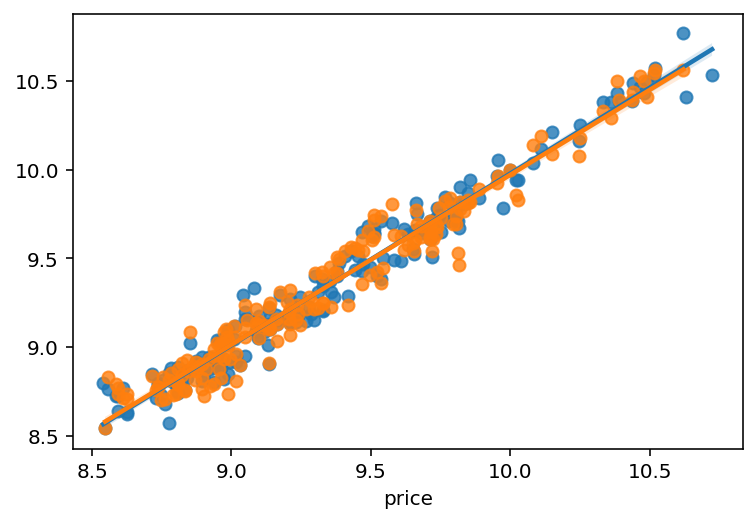

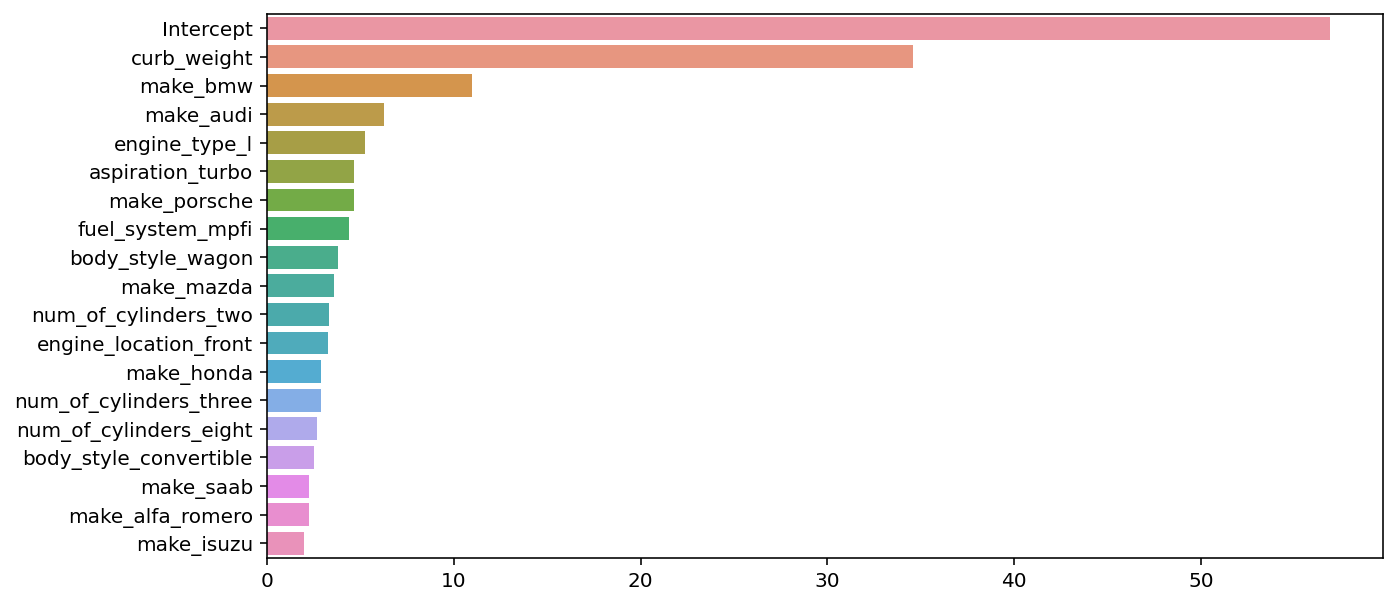

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     212.1
Date:                Sat, 15 Oct 2022   Prob (F-statistic):          1.26e-108
Time:                        12:47:07   Log-Likelihood:                 169.02
No. Observations:                 194   AIC:                            -300.0
Df Residuals:                     175   BIC:                            -238.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

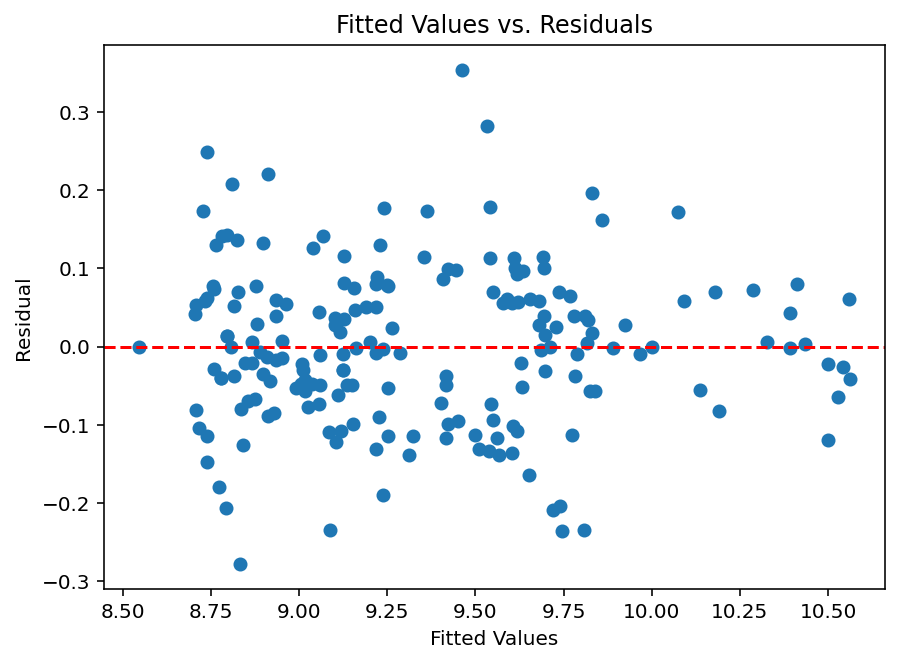

In [11]:
if __name__=="__main__":
    data_obj = Data("cleaned_data_project1.csv","price")
    num_cols, targetcol, data, cat_cols = data_obj.get_inputs()
    #There is presence of heteroscedasticity
    data['price'] = np.log(data['price'])
    #data.info()
    model = smf.ols(targetcol+'~'+'+'.join(num_cols+cat_cols),data=data).fit()
    #print(model.summary())
    print("Adj R2 of old model:",model.rsquared_adj)
    print("Adj R2 of old model:",model.rsquared_adj)
    sns.regplot(data[targetcol],model.fittedvalues)
    num_cols, cat_cols = removal_on_vif(targetcol, data, num_cols, cat_cols)
    outliers = influential_points(targetcol, num_cols, cat_cols, data)
    data = data.drop(outliers).reset_index()
    print("length of data after removing outliers:",len(data))
    num_cols, cat_cols = removal_on_pvalue(targetcol, num_cols, cat_cols, data)
    num_cols, cat_cols = anovatyp1_removal(targetcol,num_cols,cat_cols,data)
    model, explanation, num_cols, cat_cols = finalmodel(targetcol,num_cols, cat_cols, data)
    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(explanation.values,explanation.index)
    plt.show()
    print(model.summary())
    mse = model.mse_resid
    msr = model.mse_model
    print("R2 of the Final Model", model.rsquared_adj)
    n_iterations = 500
    lower, upper = bootstrap_confidence(n_iterations, targetcol, num_cols, cat_cols, data)
    conf_interval, pred_interval = ci_pi(targetcol, num_cols, cat_cols,data)
    print("Confidence Interval for a given sample is:",conf_interval)
    print("prediction Interval for given sample is:",pred_interval)
    residuals_plot(model.fittedvalues,model.resid)